# Базы данных для аналитиков. Основы ETL
## Домашнее задание 3. Типовые методы анализа данных

In [113]:
from ipywidgets import HTML
from IPython import display
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt

Главная задача: сделать RFM-анализ на основе данных по продажам за 2 года (из предыдущего дз).

Что делаем:
1. Определяем критерии для каждой буквы R, F, M (т.е. к примеру, R – 3 для клиентов, которые покупали <= 30 дней от последней даты в базе, R – 2 для клиентов, которые покупали > 30 и менее 60 дней от последней даты в базе и т.д.)
2. Для каждого пользователя получаем набор из 3 цифр (от 111 до 333, где 333 – самые классные пользователи)
3. Вводим группировку, к примеру, 333 и 233 – это Vip, 1XX – это Lost, остальные Regular ( можете ввести боле глубокую сегментацию)
4. Для каждой группы из п. 3 находим кол-во пользователей, кот. попали в них и % товарооборота, которое они сделали на эти 2 года.
5. Проверяем, что общее кол-во пользователей бьется с суммой кол-во пользователей по группам из п. 3 (если у вас есть логические ошибки в создании групп, у вас не собьются цифры). То же самое делаем и по деньгам.

Результаты присылаем скрином или в пдф (где можно увидеть название группы, правила попадания в группу, кол-во пользователей, их товарооборот, а так же процент по кол-ву пользвателей и по деньгам)

In [4]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/65kLpVLV464" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

HTML(value='<iframe width="560" height="315" src="https://www.youtube.com/embed/65kLpVLV464" frameborder="0" a…

### Решение
#### Подключение к базе

In [14]:
conn = sqlite3.connect("h1.db")

#### Составление сводной таблицы и помещения в датасет

In [15]:
df.columns

Index(['id_o', 'user_id', 'price', 'o_date'], dtype='object')

In [11]:
df.to_csv('orders.csv')

In [72]:
query = """
SELECT 
    user_id,
    MAX(o_date) as 'last_date',
    COUNT(id_o) as 'orders_count',
    SUM(price) as 'orders_sum'
FROM orders
GROUP BY user_id
"""

In [73]:
df = pd.read_sql_query(query, conn, parse_dates=['last_date'])

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015119 entries, 0 to 1015118
Data columns (total 4 columns):
user_id         1015119 non-null object
last_date       1015119 non-null datetime64[ns]
orders_count    1015119 non-null int64
orders_sum      1015119 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 31.0+ MB


#### Подготовка к RFM-анализу

Оценим количество покупок по временной линии - это поможет нам задать критерии для R-анализа

In [83]:
df.orders_sum.quantile(.50),df.orders_sum.quantile(.90),


(1840.0, 9298.0)

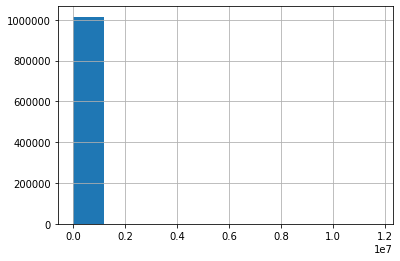

In [78]:
df.orders_sum.hist()

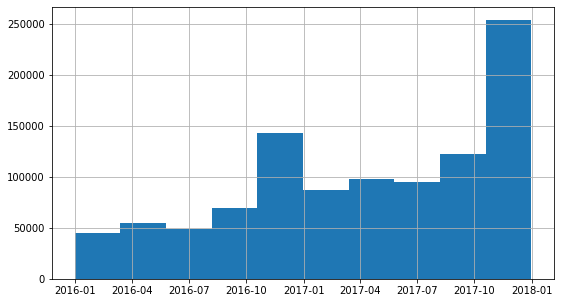

In [62]:
df.last_date.hist(figsize=(9,5));

Последняя дата в базе:

In [91]:
max_date = df.last_date.max()
max_date

Timestamp('2017-12-31 00:00:00')

Напишем функции для RFM-анализа

In [85]:
def r_classification(last_date):
    """
    R – 3 для клиентов, которые покупали <= 30 дней от последней даты в базе, 
    R – 2 для клиентов, которые покупали > 30 и менее 60 дней от последней даты в базе
    R - 1 для клиентов, которые покупали > 60 дней назад от последней даты в базе
    """
    day_delta = (max_date - last_date).days
    if day_delta <= 30:
        return '3'
    elif day_delta <= 60:
        return '2'
    else:
        return '1'
    
def f_classification(orders):
    """
    F - 3 для клиентов, совершивших >= 30 покупок
    F - 2 для клиентов, совершивших от 10 до 30 покупок
    F - 1 для клиентов, совершивших менее 10 покупок
    """
    if orders >= 30:
        return '3'
    elif orders >= 10:
        return '2'
    else:
        return '1'
    
def m_classification(orders_sum):
    """
    M - 3 для клиентов, совершивших покупки на сумму >= 10.000 
    M - 2 для клиентов, совершивших покупки на сумму от 2.000 до 10.000 
    M - 1 для клиентов, совершивших покупки на сумму < 2.000
    """
    if orders_sum >= 10000:
        return '3'
    elif orders_sum >= 2000:
        return '2'
    else:
        return '1'

In [86]:
df['r'] = df.last_date.apply(r_classification)
df['f'] = df.orders_count.apply(f_classification)
df['m'] = df.orders_sum.apply(m_classification)

In [93]:
df['rfm'] = df[['r', 'f', 'm']].apply(lambda x: f'{x[0]}{x[1]}{x[2]}', axis = 1)

### Вводим группировку, к примеру, 333 и 233 – это Vip, 1XX – это Lost, остальные Regular

In [94]:
def rfm_classify(rfm: str):
    if rfm in ['333', '233']:
        return 'VIP'
    elif rfm.startswith('1'):
        return 'Lost'
    else:
        return 'Regular'

In [95]:
df['status'] = df.rfm.apply(rfm_classify)

Построим гистограмму распределения клиентов во стастусу

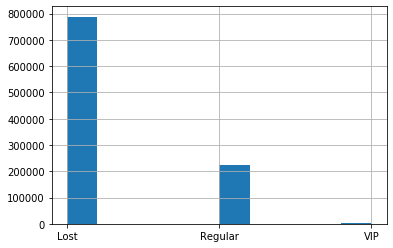

In [96]:
df.status.hist()

### Для каждой группы из п. 3 находим кол-во пользователей, кот. попали в них и % товарооборота, которое они сделали на эти 2 года.

In [111]:
result = df.pivot_table(
    ['user_id', 'orders_sum'],
    index='status',
    aggfunc={
        'user_id': np.ma.count,
        'orders_sum': sum
    },
#     columns='status', 
    margins=True
)

Получим сводную таблицу по %товарооборота и количеству клиентов в категории

In [125]:
pd.options.display.float_format = '{0:.0f}'.format
result

,orders_sum,user_id
status,,
Lost,2971660533,788069
Regular,1278036258,225032
VIP,292209817,2018
All,4541906608,1015119


### Проверяем, что общее кол-во пользователей бьется с суммой кол-во пользователей по группам. То же самое делаем и по деньгам.

In [130]:
print('Сумма заказов по деньгам: ', df.orders_sum.sum())
print('Общее количество клиентов:', df.user_id.count())

Сумма заказов по деньгам:  4541906608.0
Общее количество клиентов: 1015119


_В заключении, могу сказать что критерии подобраны неверно, исходя из результатирующей статистики. Однако, для этого надо разбираться в предметной области. Данная работа показывает что по крайней мере логика верна._